# Deep Learning Models for stock prediction - LSTM

# Import necessary libraries

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings("ignore")

## Import data

The data was downloaded from Bloomberg on:
* Exchange rate of Vietnam with its major trading partners: the US
* Precious metal spot price and future price: Palladium
* Global Stock Indices: Hang Seng Index, Nasdaq 100, Nasdaq Composite, Nikkei 225, SP500, DOJI, Shanghai Shenzhen CSI3000, Shanghai Shenzhen Composite and Singapore Stock Index
* Volatility stock index: VIX Index

The data will be imported from previous EDA session, which has been cleaned and excluded less important variables

In [74]:
# Import data
data = pd.read_csv('data.csv')

# Transfer date column to date time
import datetime
data['Date'] = pd.to_datetime(data['Date'], format = '%m/%d/%Y')

# Turn date into index
data.set_index('Date', inplace = True)

In [75]:
# View the data
data.head()

,index_sp500,spot_palladium,index_shsz_csi300,index_vni
Date,,,,
2007-07-02,1519.43,368.5,16130,994.17
2007-07-03,1524.87,365.0,16131,977.30
2007-07-04,1522.19,366.0,16130,1013.56
2007-07-05,1525.40,365.5,16130,1012.82
2007-07-06,1530.44,367.0,16135,1010.53


In [76]:
# Basic stats of the dataset
data.describe()

,index_sp500,spot_palladium,index_shsz_csi300,index_vni
count,4175.000000,4175.000000,4175.000000,4175.000000
mean,2260.290129,1027.290549,21234.396886,735.764041
std,1055.352200,677.881578,2228.786620,304.453259
min,676.530000,164.500000,15810.000000,235.500000
25%,1354.535000,585.835000,20817.000000,489.695000
50%,2049.580000,765.900000,21815.000000,614.420000
75%,2887.915000,1425.245000,23028.500000,973.865000
max,4796.560000,3171.880000,24867.000000,1528.570000


# Deep Learning model - LSTM

We will build two versions of the model
- Univariate LSTM prediction (using the target VN-Index price only)
- Multivariate LSTM prediction (combine with global stock indices and commodity price)

## Prepare model - Multivariate

In [77]:
# Import necessary libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

In [78]:
# Scaling the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)
data_scaled[-10:]

array([[0.87555673, 0.4144172 , 0.85282102, 0.67274007],
       [0.901008  , 0.40654989, 0.85138567, 0.67762766],
       [0.89542066, 0.39567331, 0.8517169 , 0.68284006],
       [0.89935267, 0.37327508, 0.85127526, 0.6881298 ],
       [0.8912071 , 0.3736741 , 0.85182732, 0.69128508],
       [0.8864717 , 0.3809063 , 0.85282102, 0.69333447],
       [0.89850802, 0.37714556, 0.85237938, 0.69511318],
       [0.89813181, 0.3650553 , 0.85469802, 0.69822206],
       [0.9028842 , 0.35391271, 0.85701667, 0.6881994 ],
       [0.91597634, 0.35443476, 0.8582312 , 0.68417023]])

In [79]:
# Split for training and test
train_time = int(round(len(data) * 0.8))

data_scaled_train = data_scaled[:train_time]
data_scaled_test = data_scaled[train_time:]

# Check the shape
print(data_scaled_train.shape)
print(data_scaled_test.shape)

(3340, 4)
(835, 4)


We will use data of 30 days to predict the movement of 7 days ahead.

In [80]:
# Setup sequence length
past_days = 30
predict_days = 7

X_train = []
y_train = []

for i in range(past_days, len(data_scaled_train) - past_days):
    X_train.append(data_scaled_train[i - past_days : i, :-1])
    y_train.append(data_scaled_train[i : i+ predict_days, -1])

# Turn train X and y to numpy
X_train = np.array(X_train)
y_train = np.array(y_train)

In [81]:
# Setup test length
X_test = []
y_test = []

for i in range(past_days, len(data_scaled_test) - past_days):
    X_test.append(data_scaled_test[i - past_days : i, :-1])
    y_test.append(data_scaled_test[i : i + predict_days, -1])

# Turn train X and y to numpy
X_test = np.array(X_test)
y_test = np.array(y_test)

In [82]:
# Check the shape
print('X train shape: ', X_train.shape)
print('y train shape: ', y_train.shape)
print('X test shape: ', X_test.shape)
print('y test shape: ', y_test.shape)

X train shape:  (3280, 30, 3)
y train shape:  (3280, 7)
X test shape:  (775, 30, 3)
y test shape:  (775, 7)


In [83]:
# Build model
model = Sequential([
    LSTM(64,  input_shape = (X_train.shape[1], X_train.shape[2]), return_sequences= True, dropout = 0.2),
    LSTM(64, return_state= False),
    Dense(1)
])

# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10 ** (epoch / 20)
)

# Initialize the optimizer
optimizer = tf.keras.optimizers.Adam()

# Compile model
model.compile(optimizer = optimizer, loss = 'mean_absolute_error')

# Check the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 30, 64)            17408     
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 50497 (197.25 KB)
Trainable params: 50497 (197.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [84]:
# Train the model
history = model.fit(X_train, y_train, batch_size = 64, epochs = 50, validation_data= (X_test, y_test))

Epoch 1/50
52/52 [==============================] - 8s 58ms/step - loss: 0.0948 - val_loss: 0.0680
Epoch 2/50
52/52 [==============================] - 2s 44ms/step - loss: 0.0657 - val_loss: 0.0985
Epoch 3/50
52/52 [==============================] - 2s 43ms/step - loss: 0.0625 - val_loss: 0.0953
Epoch 4/50
52/52 [==============================] - 2s 42ms/step - loss: 0.0624 - val_loss: 0.1090
Epoch 5/50
52/52 [==============================] - 2s 42ms/step - loss: 0.0583 - val_loss: 0.1138
Epoch 6/50
52/52 [==============================] - 2s 42ms/step - loss: 0.0593 - val_loss: 0.1227
Epoch 7/50
52/52 [==============================] - 2s 40ms/step - loss: 0.0511 - val_loss: 0.2022
Epoch 8/50
52/52 [==============================] - 2s 40ms/step - loss: 0.0483 - val_loss: 0.1697
Epoch 9/50
52/52 [==============================] - 2s 42ms/step - loss: 0.0487 - val_loss: 0.2294
Epoch 10/50
52/52 [==============================] - 2s 42ms/step - loss: 0.0453 - val_loss: 0.2105
Epoch 11/

In [94]:
# Predict the model
prediction = model.predict(X_test)

# Refit the model
scaler.fit(data[['index_vni']])

# Rescale the predictions
prediction_rescaled = scaler.inverse_transform(prediction)

 1/25 [>.............................] - ETA: 0s

25/25 [==============================] - 0s 11ms/step


In [95]:
# Obtain actual price
actual = data['index_vni'].iloc[-775:]

# Turn prediction into pandas dataframe with date
prediction = pd.DataFrame(data = prediction_scaled, index = actual.index)

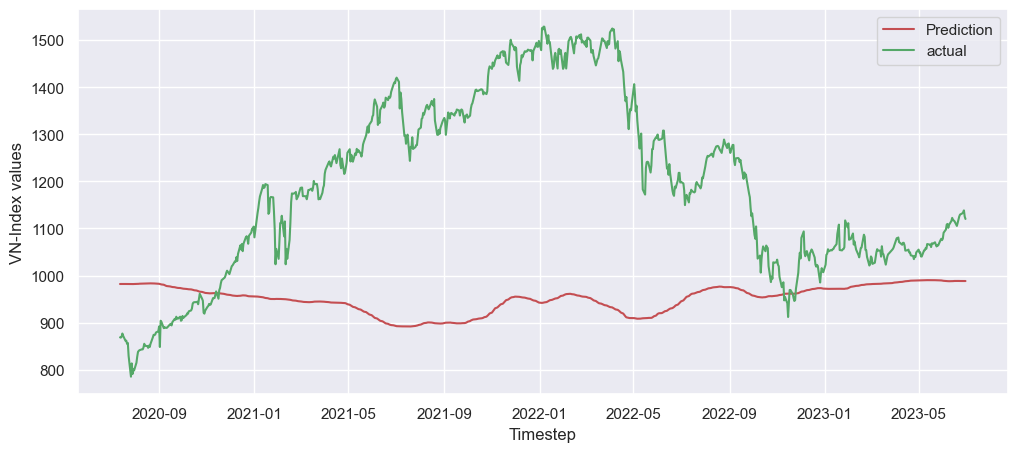

In [96]:
# Compare the prediction and actual values
fig, ax = plt.subplots(figsize = (12,5))

ax.plot(prediction, color = 'r', label = 'Prediction')
ax.plot(actual, color = 'g', label = 'actual')
plt.legend()
ax.set_xlabel('Timestep')
ax.set_ylabel('VN-Index values')
plt.show()

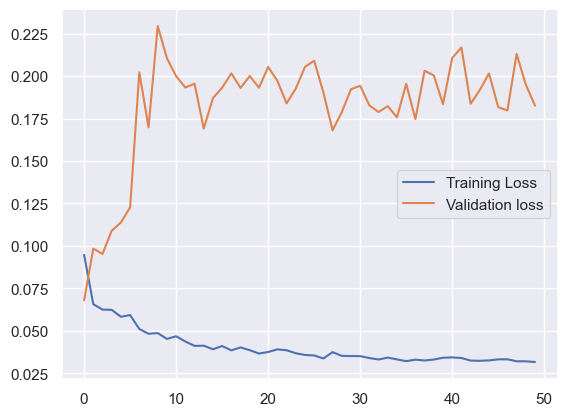

In [97]:
# Plot training and test lost
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation loss')
plt.legend()
plt.show()

In [98]:
# Define MAE and MSE
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse

# Calculate mae
mae_lstm_uni = mae(actual, predictions)
mse_lstm_uni = mse(actual, predictions)

# Print out result
print(f"MAE: {mae_lstm_uni} \n"
      f"MSE: {mse_lstm_uni}")

MAE: 1189.6655978030635 
MSE: 1450955.8413044284


After experimenting with both simple ML and DL (without any further hyperparameters tuning), I came to a conclusion that simple model might better fit with my hypothesis. The reason I stop experimenting more is that I just want to confirm whether simple ML and DL models can detect the cointegration - long-run relationship between global stock indices and commodity prices. If models are further tuned more, it would be more about technical configuration and manipulating results through hyperparameters tuning.